In [1]:
import sys
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import cm

# Custom package
sys.path.append('/home/rrp000/sea_ice/code/')
from icepack import load_dataset
from icepack.analysis import *
from icepack.splot import *

# Some useful lists and dicts
monthletters = ['J','F','M','A','M','J','J','A','S','O','N','D']
monthstr = ['01','02','03','04','05','06','07','08','09','10','11','12']
monthdict = {1:r'$\mathbf{January}$',
             2:r'$\mathbf{February}$',
             3:r'$\mathbf{March}$',
             4:r'$\mathbf{April}$',
             5:r'$\mathbf{May}$',
             6:r'$\mathbf{June}$',
             7:r'$\mathbf{July}$',
             8:r'$\mathbf{August}$',
             9:r'$\mathbf{September}$',
             10:r'$\mathbf{October}$',
             11:r'$\mathbf{November}$',
             12:r'$\mathbf{December}$'}

method = 'mean'
daterange = (2000,2019)
daterange_clim = (1981,2010)
grid_path = "~/sea_ice/data/grids/grid_1x1.nc"
grid = xr.open_dataset(grid_path)

# Open datasets

In [2]:
# open data
sic = format_time_coord(load_dataset('Had2CIS','siconc'),'1959-01','2024-12',freq='M')

# calculate SIE and anomalies
sie_Had2CIS = get_iceextent(sic, grid, lat_bounds=(-90,0), sic_label='sicn', lat_label='lat', lon_label='lon', ensemble=None)
sie_anom_Had2CIS = get_anomalies(sie_Had2CIS,'SIE',ref_period=daterange)
sie_clim_Had2CIS = get_climatology(sie_Had2CIS,var='SIE',ref_period=daterange_clim)

/home/rrp000/sea_ice/code/icepack/analysis.py:152: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if grid_area.dims == {'lon':360, 'lat':180}:


In [3]:
# CELL TAKES ~1 MINUTE TO RUN

# open data and format time
sic_CanESM5_init = load_dataset('CanESM5.1_i','siconc')
sic_CanESM5_init = [format_time_coord(data,f'1980-{monthstr[i]}',f'202{3+int(np.heaviside(i,0))}-{monthstr[i-1]}',freq='M') for i,data in enumerate(sic_CanESM5_init)]

# calculate SIE (ensemble mean) and SIE anomalies
print("Calculating SIE")
sie_CanESM5_init = []
for i,sic in enumerate(sic_CanESM5_init):
    sie_CanESM5_init.append(get_iceextent(sic, grid, lat_bounds=(-90,0), sic_label='siconc', lat_label='lat', lon_label='lon', ensemble='mean', sic_factor=1e-2))
sie_anom_CanESM5_init = [get_anomalies(sie,'SIE',ref_period=daterange) for sie in sie_CanESM5_init]

# add a lead time coordinate to the SIE data set
print("Adding a lead time coordinate")
for i in range(len(sic_CanESM5_init)):
    im = i + 1
    sic_CanESM5_init[i] = sic_CanESM5_init[i].mean(dim='ensemble').assign_coords(lead=(sic_CanESM5_init[i]['time.month'] - im)%12) * 1e-2
    sie_CanESM5_init[i]['lead'] = (sie_CanESM5_init[i]['time.month'] - im)%12
    sie_anom_CanESM5_init[i]['lead'] = (sie_anom_CanESM5_init[i]['time.month'] - im)%12

# re-sort by leadtime
sic_CanESM5_init_lt = [xr.merge([sic_CanESM5_init[im-1].where(sic_CanESM5_init[im-1]['lead']==lead,drop=True) for im in np.arange(1,13)]) for lead in range(12)]
sie_CanESM5_init_lt = [xr.merge([sie_CanESM5_init[im-1].where(sie_CanESM5_init[im-1]['lead']==lead,drop=True) for im in np.arange(1,13)]) for lead in range(12)]
sie_anom_CanESM5_init_lt = [xr.merge([sie_anom_CanESM5_init[im-1].where(sie_anom_CanESM5_init[im-1]['lead']==lead,drop=True) for im in np.arange(1,13)]) for lead in range(12)]

# Calculate climatology
sic_clim_CanESM5_init = [get_climatology(sic,var='siconc',ref_period=daterange_clim) for sic in sic_CanESM5_init_lt]
sie_clim_CanESM5_init = [get_climatology(sie,var='SIE',ref_period=daterange_clim) for sie in sie_CanESM5_init_lt]

Calculating SIE


/fs/homeu2/eccc/crd/ccrn_shr/rrp000/sea_ice/code/icepack/analysis.py:152: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if grid_area.dims == {'lon':360, 'lat':180}:
/fs/homeu2/eccc/crd/ccrn_shr/rrp000/sea_ice/code/icepack/analysis.py:152: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if grid_area.dims == {'lon':360, 'lat':180}:
/fs/homeu2/eccc/crd/ccrn_shr/rrp000/sea_ice/code/icepack/analysis.py:152: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from di

Adding a lead time coordinate


In [4]:
# CELL TAKES ~1 MINUTE TO RUN

# open data and format time
sic_GEM5NEMO_init = load_dataset('GEM5.2-NEMO_i','siconc')
sic_GEM5NEMO_init = [format_time_coord(data,f'1990-{monthstr[i]}',f'202{int(np.heaviside(i,0))}-{monthstr[i-1]}',freq='M') for i,data in enumerate(sic_GEM5NEMO_init)]

# calculate SIE (ensemble mean) and SIE anomalies
print("Calculating SIE")
grid['lon'] = grid['lon'] + 0.5
sie_GEM5NEMO_init = []
for i,sic in enumerate(sic_GEM5NEMO_init):
    sie_GEM5NEMO_init.append(get_iceextent(sic, grid, lat_bounds=(-90,0), sic_label='sicn', lat_label='lat', lon_label='lon', ensemble='mean'))
sie_anom_GEM5NEMO_init = [get_anomalies(sie,'SIE',ref_period=daterange) for sie in sie_GEM5NEMO_init]

# add a lead time coordinate to the SIE data set, and resort by lead time
print("Adding a lead time coordinate")
for i in range(len(sie_GEM5NEMO_init)):
    im = i + 1
    sic_GEM5NEMO_init[i] = sic_GEM5NEMO_init[i].mean(dim='ensemble').assign_coords(lead=(sic_GEM5NEMO_init[i]['time.month'] - im)%12)
    sie_GEM5NEMO_init[i]['lead'] = (sie_GEM5NEMO_init[i]['time.month'] - im)%12
    sie_anom_GEM5NEMO_init[i]['lead'] = (sie_anom_GEM5NEMO_init[i]['time.month'] - im)%12
sic_GEM5NEMO_init_lt = [xr.merge([sic_GEM5NEMO_init[im-1].where(sic_GEM5NEMO_init[im-1]['lead']==lead,drop=True) for im in np.arange(1,13)]) for lead in range(12)]
sie_GEM5NEMO_init_lt = [xr.merge([sie_GEM5NEMO_init[im-1].where(sie_GEM5NEMO_init[im-1]['lead']==lead,drop=True) for im in np.arange(1,13)]) for lead in range(12)]
sie_anom_GEM5NEMO_init_lt = [xr.merge([sie_anom_GEM5NEMO_init[im-1].where(sie_anom_GEM5NEMO_init[im-1]['lead']==lead,drop=True) for im in np.arange(1,13)]) for lead in range(12)]

# Calculate climatology
sic_clim_GEM5NEMO_init = [get_climatology(sic,var='sicn',ref_period=daterange_clim) for sic in sic_GEM5NEMO_init_lt]
sie_clim_GEM5NEMO_init = [get_climatology(sie,var='SIE',ref_period=daterange_clim) for sie in sie_GEM5NEMO_init_lt]

Calculating SIE


/fs/homeu2/eccc/crd/ccrn_shr/rrp000/sea_ice/code/icepack/analysis.py:152: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if grid_area.dims == {'lon':360, 'lat':180}:
/fs/homeu2/eccc/crd/ccrn_shr/rrp000/sea_ice/code/icepack/analysis.py:152: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if grid_area.dims == {'lon':360, 'lat':180}:
/fs/homeu2/eccc/crd/ccrn_shr/rrp000/sea_ice/code/icepack/analysis.py:152: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from di

Adding a lead time coordinate


/space/hall5/sitestore/eccc/crd/ccrn/users/rrp000/miniconda3/envs/icepy/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/space/hall5/sitestore/eccc/crd/ccrn/users/rrp000/miniconda3/envs/icepy/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/space/hall5/sitestore/eccc/crd/ccrn/users/rrp000/miniconda3/envs/icepy/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/space/hall5/sitestore/eccc/crd/ccrn/users/rrp000/miniconda3/envs/icepy/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/space/hall5/sitestore/eccc/crd/ccrn/users/rrp000/minico

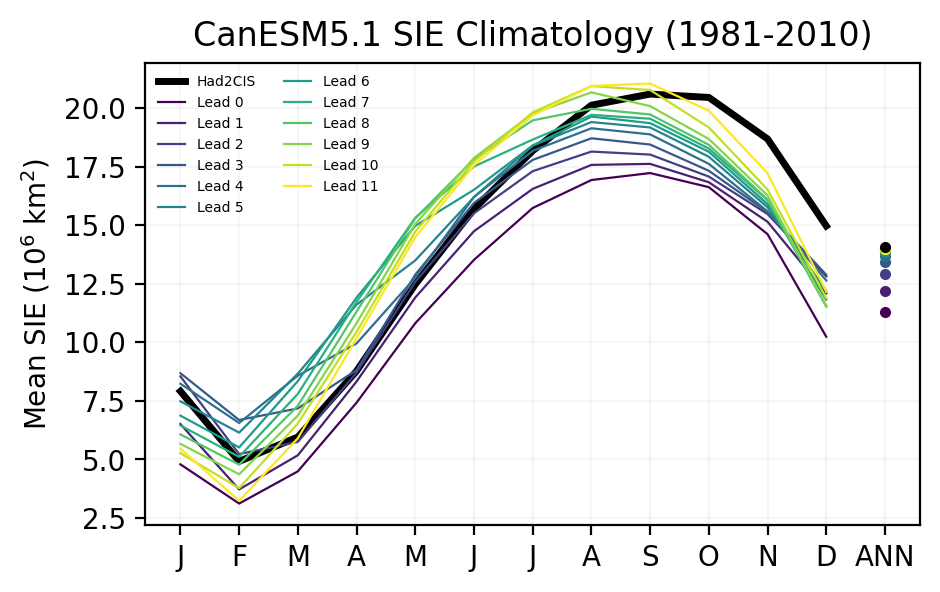

In [5]:
fix,ax=plt.subplots(1,1,figsize=(5,3),dpi=200)

# The data to be plotted. Labels for legend are defined in a previous cell.
xticklabels = ['J','F','M','A','M','J','J','A','S','O','N','D','ANN']
colors = cm.viridis(np.linspace(0,1,12))
labels = ['Had2CIS','Lead 0','Lead 1','Lead 2','Lead 3','Lead 4','Lead 5','Lead 6','Lead 7','Lead 8','Lead 9','Lead 10','Lead 11']

# Plot the data
ax.plot(sie_clim_Had2CIS['SIE'].values,color='black',label="Had2CIS",linewidth=2.5)
for i,data in enumerate(sie_clim_CanESM5_init):
    ax.plot(data['SIE'].values,'-',color=colors[i],label=labels[i+1],linewidth=.8)
for i,data in enumerate(sie_clim_CanESM5_init):
    ax.plot(12,data['overall_mean'].values,'.',color=colors[i])
ax.plot(12,sie_clim_Had2CIS['overall_mean'].values,'.',color='black')

# Other details of the plots
ax.set_xticks(np.arange(13))
ax.set_xticklabels(xticklabels)
ax.set_xlabel(None)
ax.set_ylabel(r"Mean SIE ($10^6\ \mathrm{km}^2$)")
ax.set_title(f"CanESM5.1 SIE Climatology ({daterange_clim[0]}-{daterange_clim[1]})")
ax.grid(alpha=0.1)
ax.legend(labels,ncols=2,fontsize=5,frameon=False)
plt.show()

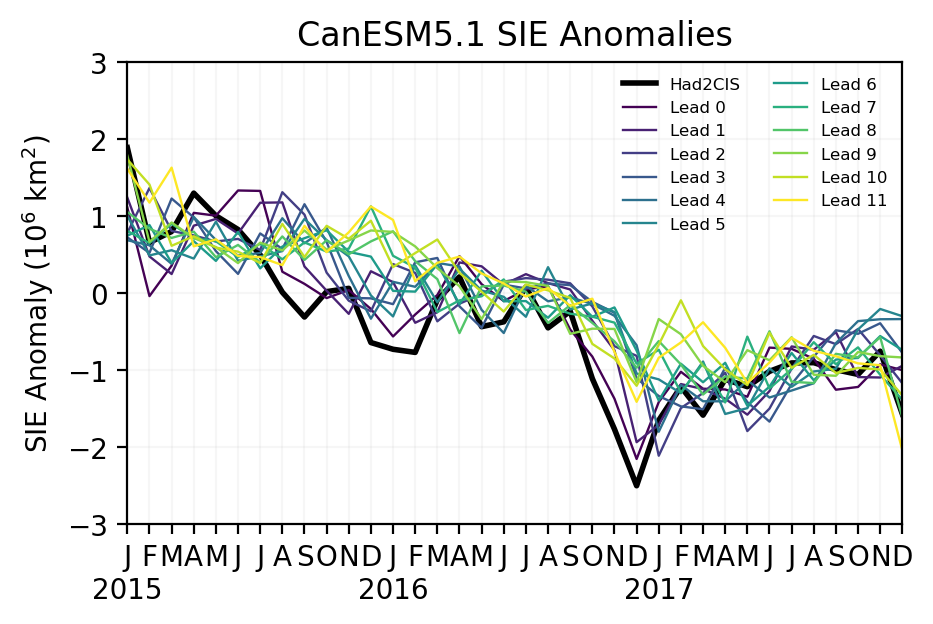

In [6]:
fix,ax=plt.subplots(1,1,figsize=(5,3),dpi=200)

# The data to be plotted, the years over which to plot, labels for legend, etc.
y0,y1 = [2015,2017]
colors = cm.viridis(np.linspace(0,1,12))
labels = ['Had2CIS','Lead 0','Lead 1','Lead 2','Lead 3','Lead 4','Lead 5','Lead 6','Lead 7','Lead 8','Lead 9','Lead 10','Lead 11']

# Plot the data
sie_anom_Had2CIS.where((sie_anom_Had2CIS['time.year']>=y0) & (sie_anom_Had2CIS['time.year']<=y1),drop=True).to_dataframe().plot.line(ax=ax,legend=False,linewidth=2,color='black')
for i,data in enumerate(sie_anom_CanESM5_init_lt):
    data = data.drop_vars('lead')
    data.where((data['time.year']>=y0) & (data['time.year']<=y1),drop=True).to_dataframe().plot.line(ax=ax,legend=False,linewidth=.85,color=colors[i])

# Other details of the plots
xlabels = monthletters*(y1-y0+1)
for i,yr in enumerate(np.arange(y0,y1+1,1)):
    xlabels[12*i] += f'\n{yr}'
ax.set_xlim(np.datetime64(f"{y0}-01"),np.datetime64(f"{y1}-12"))
ax.set_xticks(np.arange(np.datetime64(f"{y0}-01"),np.datetime64(f"{y1+1}-01"),np.timedelta64(1,"M")))
ax.set_xticklabels(xlabels)
ax.set_xlabel(None)
ax.set_ylabel(r"SIE Anomaly ($10^6\ \mathrm{km}^2$)")
ax.set_ylim(-3,3)
ax.set_title("CanESM5.1 SIE Anomalies")
ax.grid(alpha=0.1)
ax.legend(labels,ncols=2,fontsize=6,frameon=False)
plt.show()

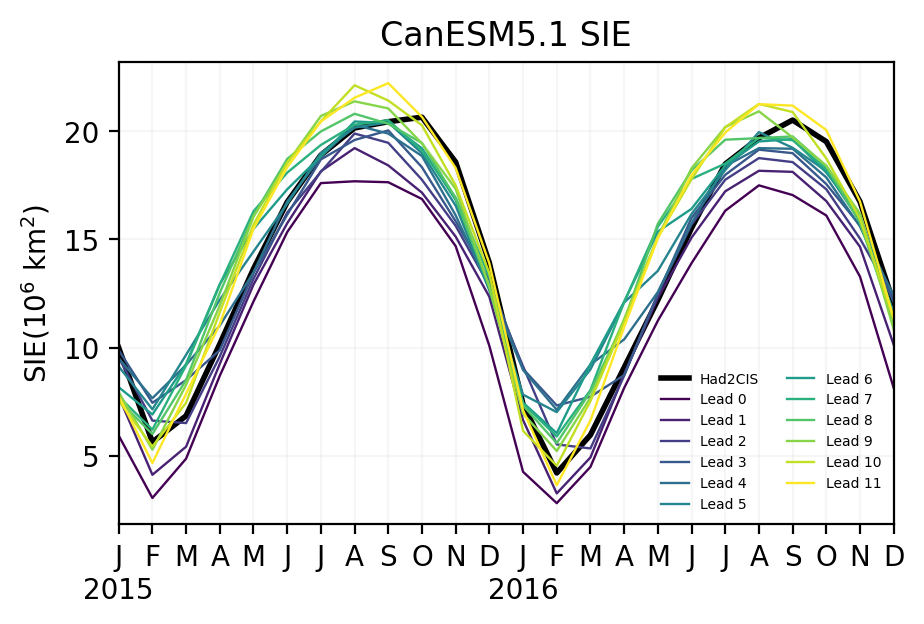

In [7]:
fix,ax=plt.subplots(1,1,figsize=(5,3),dpi=200)

# The data to be plotted, the years over which to plot, labels for legend, etc.
y0,y1 = [2015,2016]
colors = cm.viridis(np.linspace(0,1,12))
labels = ['Had2CIS','Lead 0','Lead 1','Lead 2','Lead 3','Lead 4','Lead 5','Lead 6','Lead 7','Lead 8','Lead 9','Lead 10','Lead 11']

# Plot the data
sie_Had2CIS.where((sie_Had2CIS['time.year']>=y0) & (sie_Had2CIS['time.year']<=y1),drop=True).to_dataframe().plot.line(ax=ax,legend=False,linewidth=2,color='black')
for i,data in enumerate(sie_CanESM5_init_lt):
    data = data.drop_vars('lead')
    data.where((data['time.year']>=y0) & (data['time.year']<=y1),drop=True).to_dataframe().plot.line(ax=ax,legend=False,linewidth=.85,color=colors[i])

# Other details of the plots
xlabels = monthletters*(y1-y0+1)
for i,yr in enumerate(np.arange(y0,y1+1,1)):
    xlabels[12*i] += f'\n{yr}'
ax.set_xlim(np.datetime64(f"{y0}-01"),np.datetime64(f"{y1}-12"))
ax.set_xticks(np.arange(np.datetime64(f"{y0}-01"),np.datetime64(f"{y1+1}-01"),np.timedelta64(1,"M")))
ax.set_xticklabels(xlabels)
ax.set_xlabel(None)
ax.set_ylabel(r"SIE($10^6\ \mathrm{km}^2$)")
# ax.set_ylim(-3,3)
ax.set_title("CanESM5.1 SIE")
ax.grid(alpha=0.1)
ax.legend(labels,ncols=2,fontsize=5,frameon=False)
plt.show()

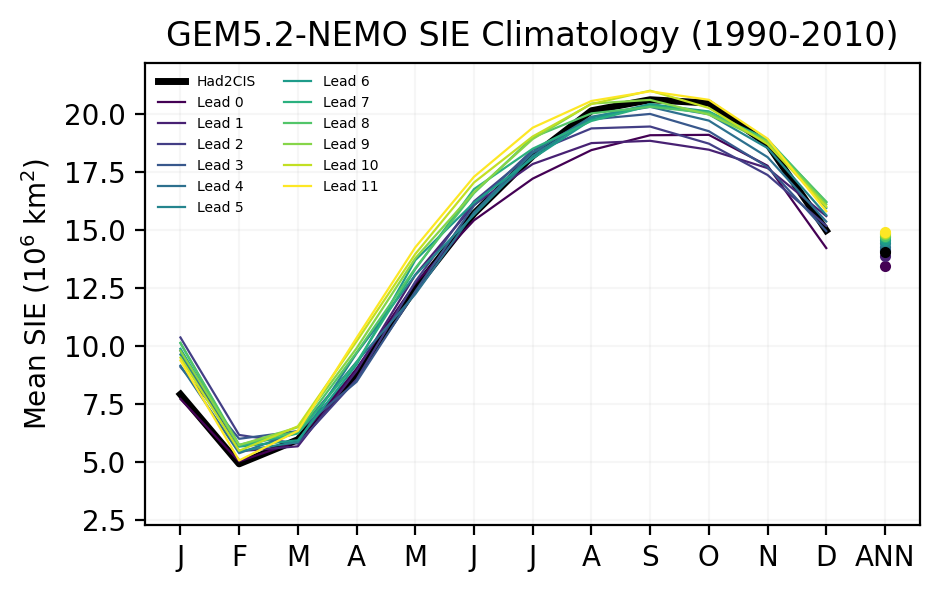

In [8]:
fix,ax=plt.subplots(1,1,figsize=(5,3),dpi=200)

# The data to be plotted. Labels for legend are defined in a previous cell.
xticklabels = ['J','F','M','A','M','J','J','A','S','O','N','D','ANN']
colors = cm.viridis(np.linspace(0,1,12))
labels = ['Had2CIS','Lead 0','Lead 1','Lead 2','Lead 3','Lead 4','Lead 5','Lead 6','Lead 7','Lead 8','Lead 9','Lead 10','Lead 11']

# Plot the data
ax.plot(sie_clim_Had2CIS['SIE'].values,color='black',label="Had2CIS",linewidth=2.5)
for i,data in enumerate(sie_clim_GEM5NEMO_init):
    ax.plot(data['SIE'].values,'-',color=colors[i],label=labels[i+1],linewidth=.8)
for i,data in enumerate(sie_clim_GEM5NEMO_init):
    ax.plot(12,data['overall_mean'].values,'.',color=colors[i])
ax.plot(12,sie_clim_Had2CIS['overall_mean'].values,'.',color='black')

# Other details of the plots
ax.set_xticks(np.arange(13))
ax.set_xticklabels(xticklabels)
ax.set_xlabel(None)
ax.set_ylabel(r"Mean SIE ($10^6\ \mathrm{km}^2$)")
ax.set_ylim(2.3,22.2)
ax.set_title(f"GEM5.2-NEMO SIE Climatology (1990-{daterange_clim[1]})")
ax.grid(alpha=0.1)
ax.legend(labels,ncols=2,fontsize=5,frameon=False)
plt.show()

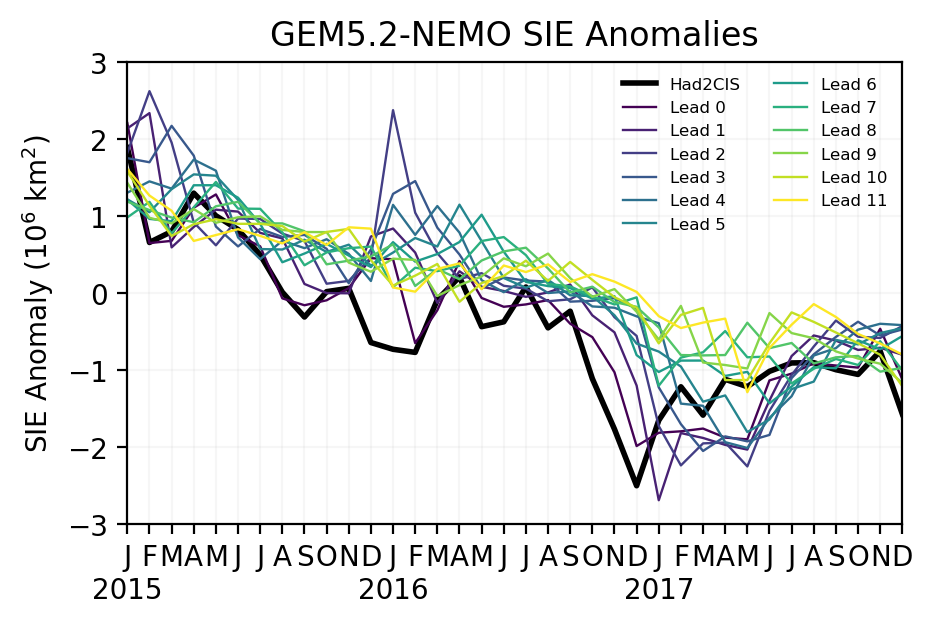

In [9]:
fix,ax=plt.subplots(1,1,figsize=(5,3),dpi=200)

# The data to be plotted, the years over which to plot, labels for legend, etc.
y0,y1 = [2015,2017]
colors = cm.viridis(np.linspace(0,1,12))
labels = ['Had2CIS','Lead 0','Lead 1','Lead 2','Lead 3','Lead 4','Lead 5','Lead 6','Lead 7','Lead 8','Lead 9','Lead 10','Lead 11']

# Plot the data
sie_anom_Had2CIS.where((sie_anom_Had2CIS['time.year']>=y0) & (sie_anom_Had2CIS['time.year']<=y1),drop=True).to_dataframe().plot.line(ax=ax,legend=False,linewidth=2,color='black')
for i,data in enumerate(sie_anom_GEM5NEMO_init_lt):
    data = data.drop_vars('lead')
    data.where((data['time.year']>=y0) & (data['time.year']<=y1),drop=True).to_dataframe().plot.line(ax=ax,legend=False,linewidth=.85,color=colors[i])

# Other details of the plots
xlabels = monthletters*(y1-y0+1)
for i,yr in enumerate(np.arange(y0,y1+1,1)):
    xlabels[12*i] += f'\n{yr}'
ax.set_xlim(np.datetime64(f"{y0}-01"),np.datetime64(f"{y1}-12"))
ax.set_xticks(np.arange(np.datetime64(f"{y0}-01"),np.datetime64(f"{y1+1}-01"),np.timedelta64(1,"M")))
ax.set_xticklabels(xlabels)
ax.set_xlabel(None)
ax.set_ylabel(r"SIE Anomaly ($10^6\ \mathrm{km}^2$)")
ax.set_ylim(-3,3)
ax.set_title("GEM5.2-NEMO SIE Anomalies")
ax.grid(alpha=0.1)
ax.legend(labels,ncols=2,fontsize=6,frameon=False)
plt.show()

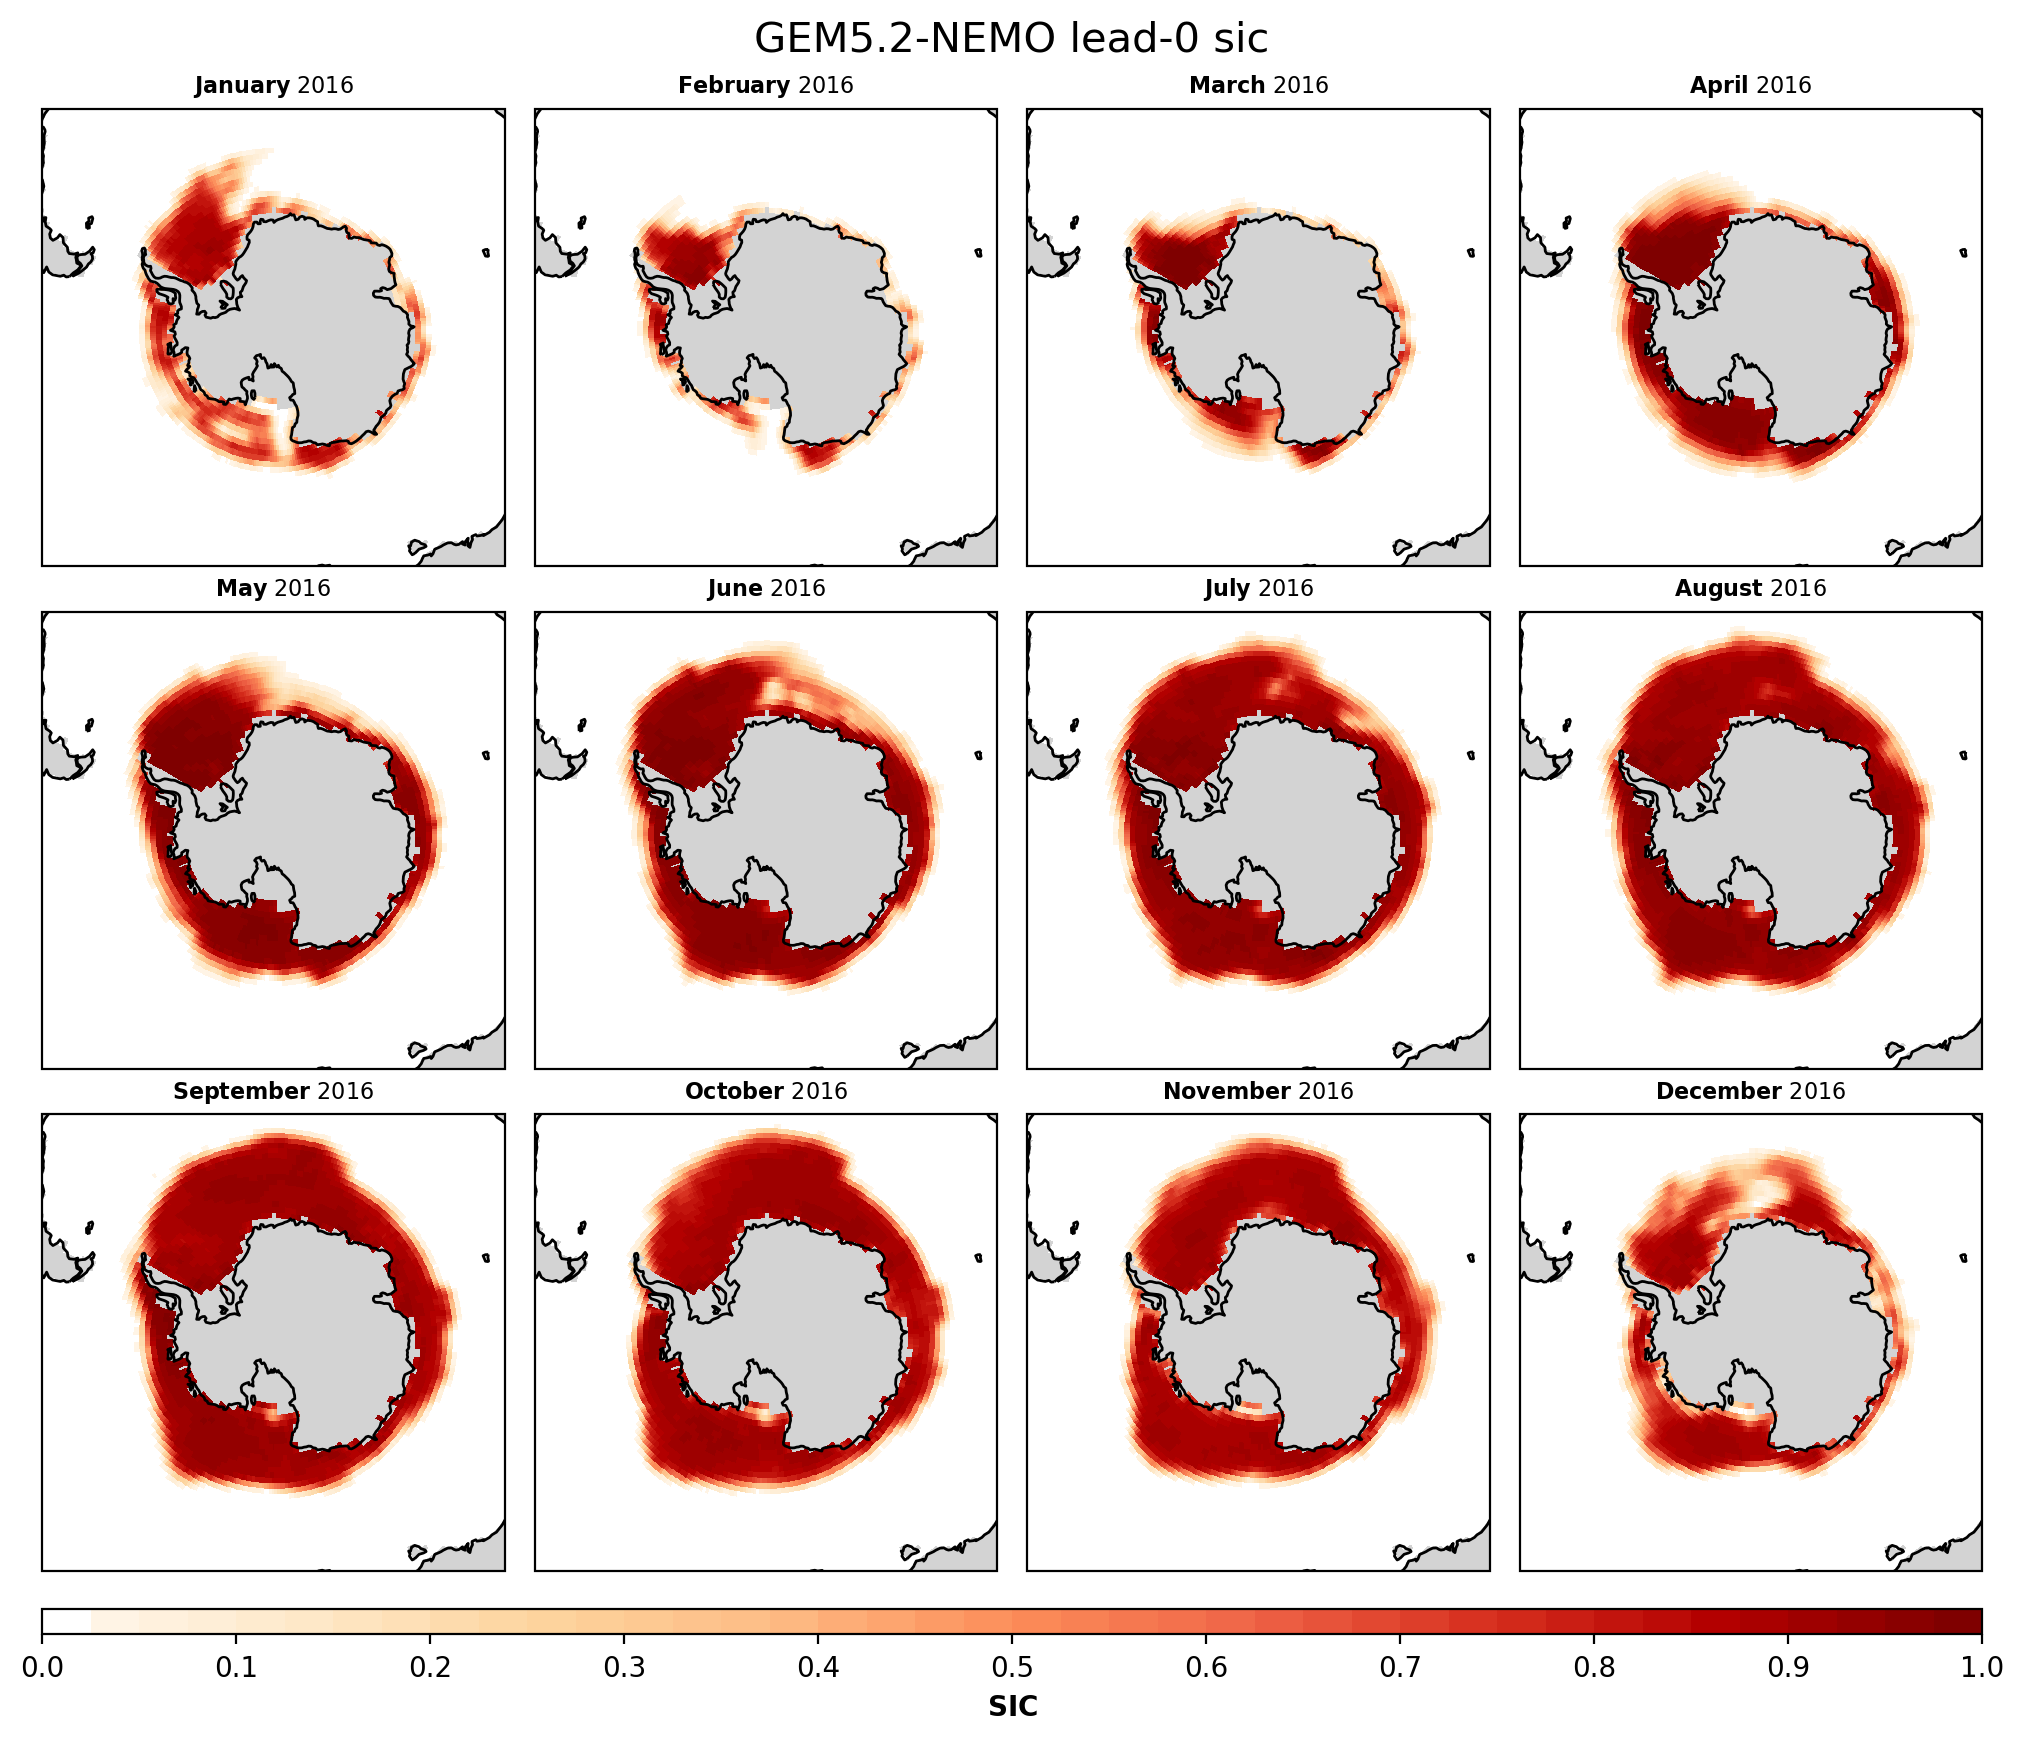

In [10]:
ncols=4
nrows=3
fig, ax = plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,10),facecolor='white',dpi=200,subplot_kw={'projection':ccrs.Orthographic(central_latitude=-90., central_longitude=0.0)})
fig.suptitle("GEM5.2-NEMO lead-0 sic", size=15, y=0.95)
get_month = [[1,2,3,4],[5,6,7,8],[9,10,11,12]]

for i in np.arange(ncols):
    for j in np.arange(nrows): 

        month = get_month[j][i]

        set_extent(ax[j][i])
        ax[j][i].coastlines()

        # sic_data = sic_CanESM5_init[0]
        # sic_data = sic_data.where((sic_data['time.month']==month) & (sic_data['time.year']==2016),drop=True)
        sic_plot = add_sic(ax[j][i], sic_GEM5NEMO_init_lt[0], anom=False, month=month, year=2016)
        sic_plot.set_clim([0., 1.])
        ax[j][i].set_title(f"{monthdict[month]} 2016", size=8)
        
plt.tight_layout()
cticks = np.linspace(0.,1.,11)
cbar = plt.colorbar(sic_plot,ax=ax,aspect=75,shrink=1,ticks=cticks,location='bottom',pad=0.02,label=r"$\mathbf{SIC}$")
plt.show()

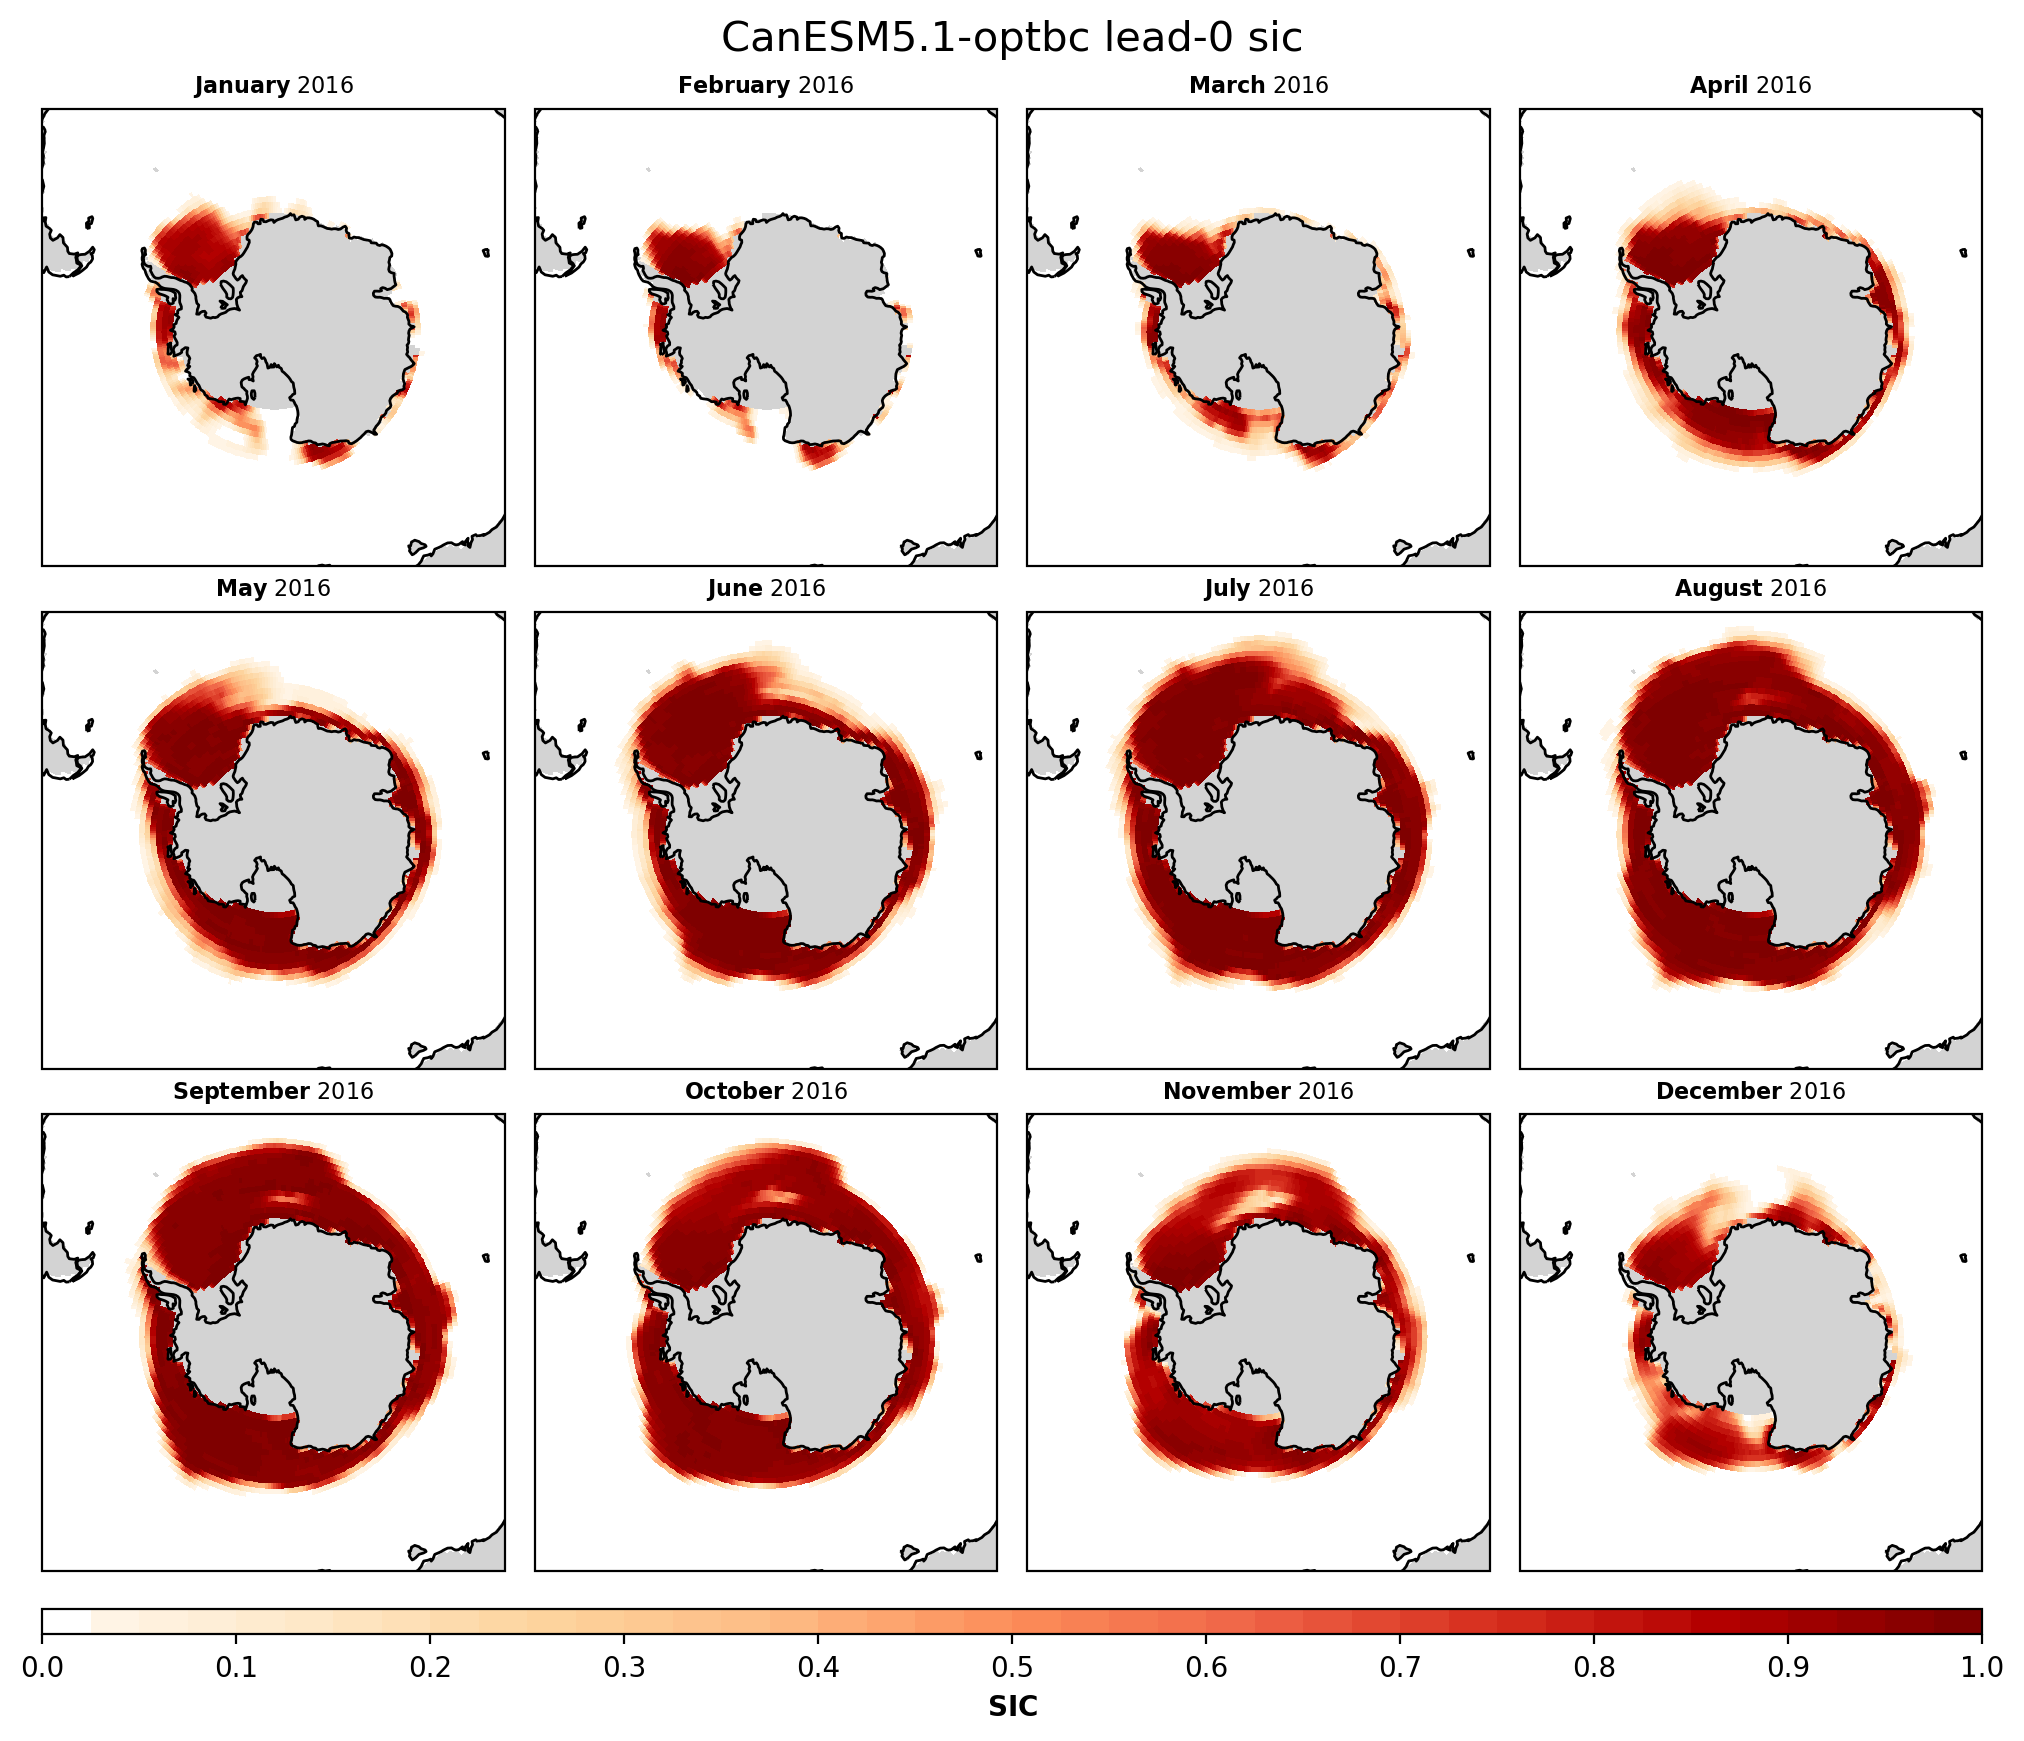

In [11]:
ncols=4
nrows=3
fig, ax = plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,10),facecolor='white',dpi=200,subplot_kw={'projection':ccrs.Orthographic(central_latitude=-90., central_longitude=0.0)})
fig.suptitle("CanESM5.1-optbc lead-0 sic", size=15, y=0.95)
get_month = [[1,2,3,4],[5,6,7,8],[9,10,11,12]]

for i in np.arange(ncols):
    for j in np.arange(nrows): 

        month = get_month[j][i]

        set_extent(ax[j][i])
        ax[j][i].coastlines()

        # sic_data = sic_CanESM5_init[0]
        # sic_data = sic_data.where((sic_data['time.month']==month) & (sic_data['time.year']==2016),drop=True)
        sic_plot = add_sic(ax[j][i], sic_CanESM5_init_lt[0], anom=False, month=month, year=2016)
        sic_plot.set_clim([0., 1.])
        ax[j][i].set_title(f"{monthdict[month]} 2016", size=8)
        
plt.tight_layout()
cticks = np.linspace(0.,1.,11)
cbar = plt.colorbar(sic_plot,ax=ax,aspect=75,shrink=1,ticks=cticks,location='bottom',pad=0.02,label=r"$\mathbf{SIC}$")
plt.show()

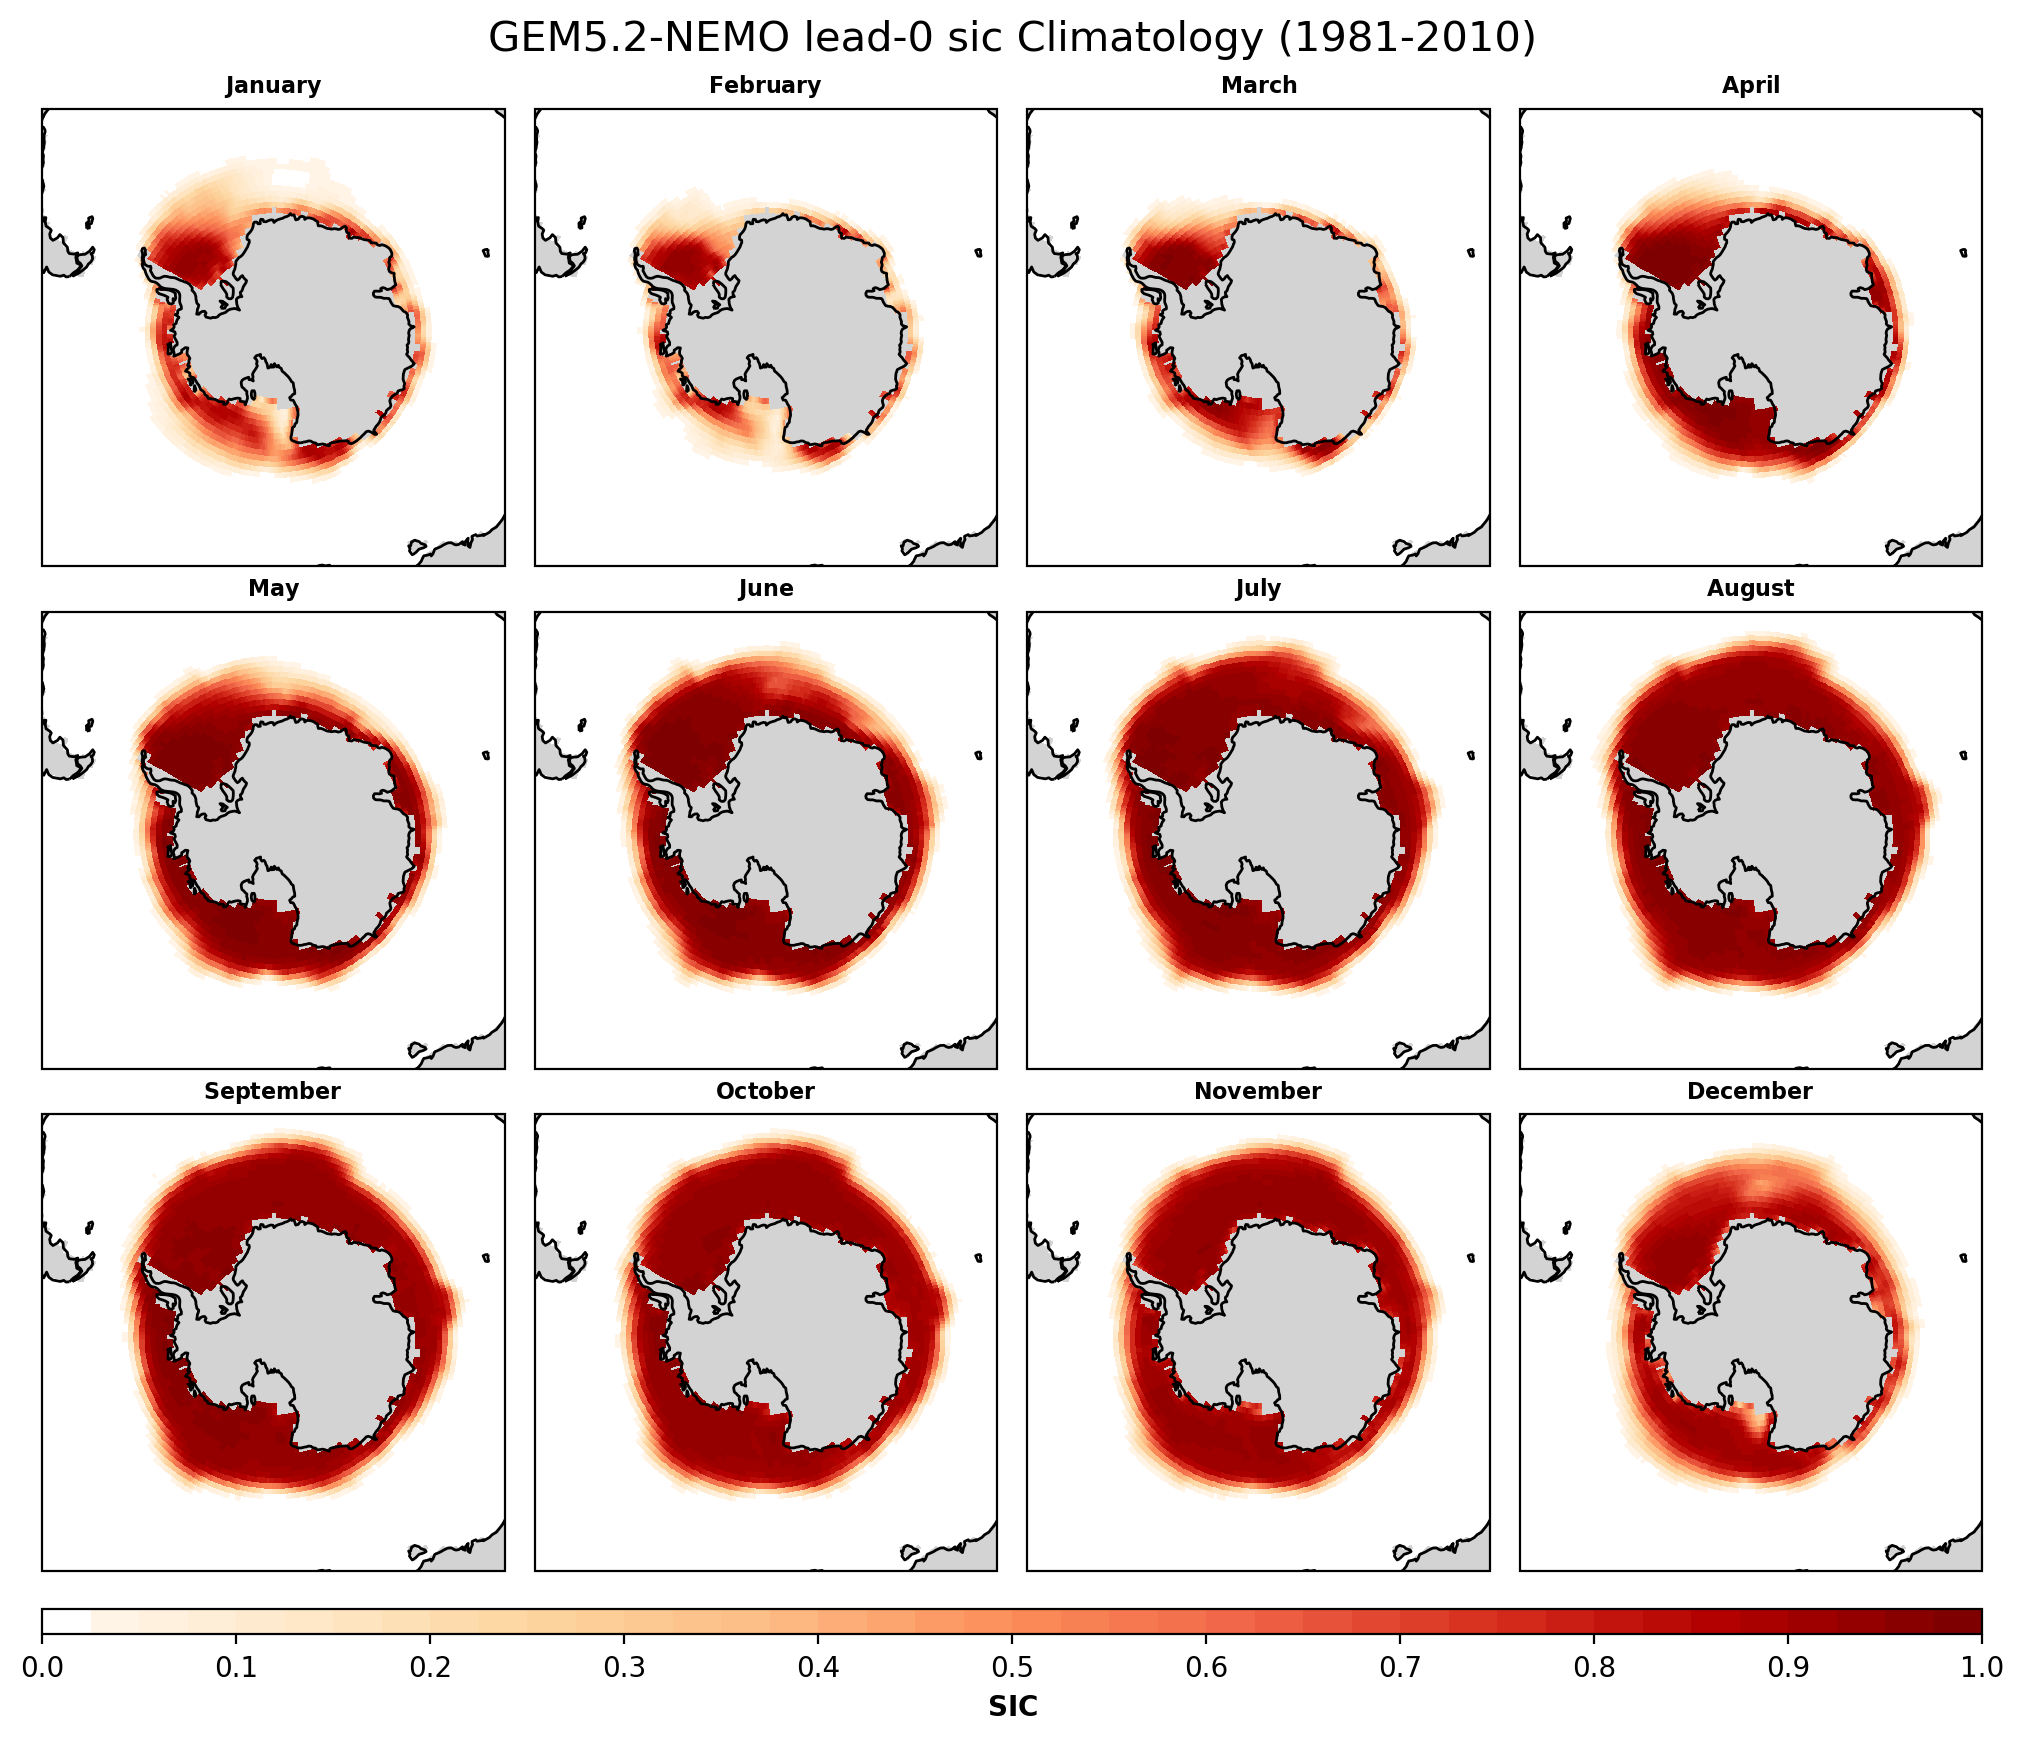

In [13]:
ncols=4
nrows=3
fig, ax = plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,10),facecolor='white',dpi=200,subplot_kw={'projection':ccrs.Orthographic(central_latitude=-90., central_longitude=0.0)})
fig.suptitle("GEM5.2-NEMO lead-0 sic Climatology (1981-2010)", size=15, y=0.95)
get_month = [[1,2,3,4],[5,6,7,8],[9,10,11,12]]

for i in np.arange(ncols):
    for j in np.arange(nrows): 

        month = get_month[j][i]

        set_extent(ax[j][i])
        ax[j][i].coastlines()

        # sic_data = sic_CanESM5_init[0]
        # sic_data = sic_data.where((sic_data['time.month']==month) & (sic_data['time.year']==2016),drop=True)
        sic_plot = add_sic(ax[j][i], sic_clim_GEM5NEMO_init[0], anom=False, month=month, year=None)
        sic_plot.set_clim([0., 1.])
        ax[j][i].set_title(f"{monthdict[month]}", size=8)
        
plt.tight_layout()
cticks = np.linspace(0.,1.,11)
cbar = plt.colorbar(sic_plot,ax=ax,aspect=75,shrink=1,ticks=cticks,location='bottom',pad=0.02,label=r"$\mathbf{SIC}$")
plt.show()

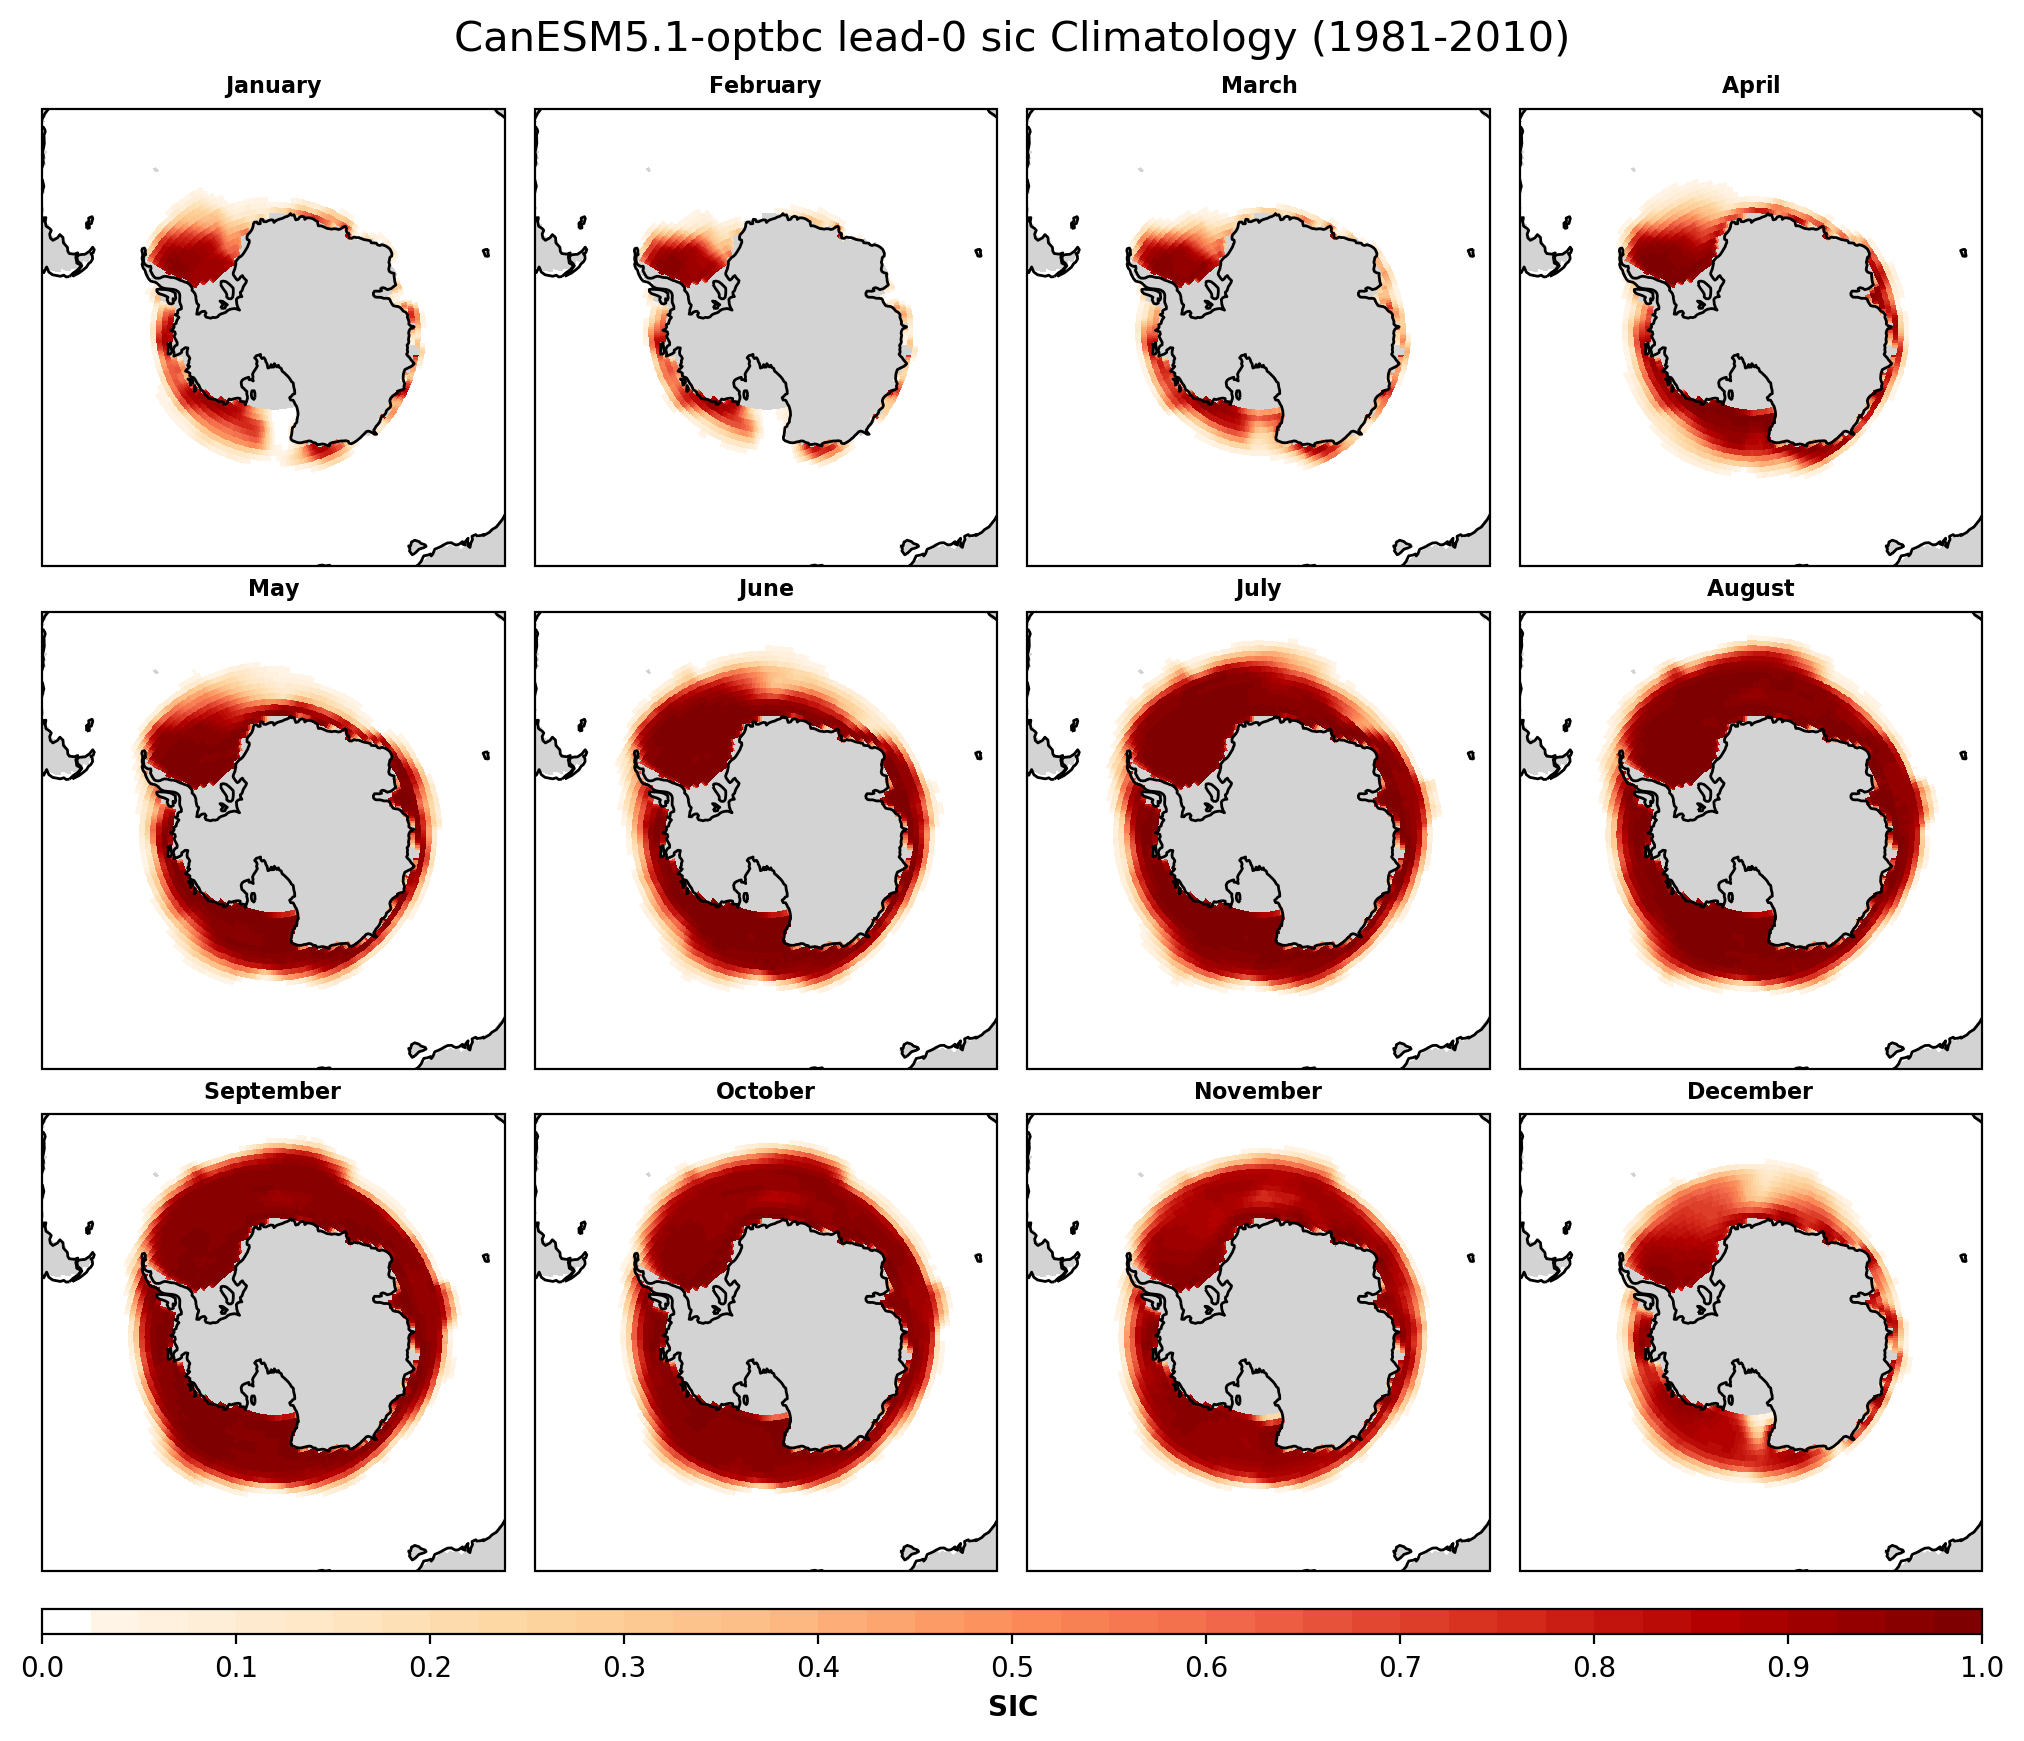

In [12]:
ncols=4
nrows=3
fig, ax = plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,10),facecolor='white',dpi=200,subplot_kw={'projection':ccrs.Orthographic(central_latitude=-90., central_longitude=0.0)})
fig.suptitle("CanESM5.1-optbc lead-0 sic Climatology (1981-2010)", size=15, y=0.95)
get_month = [[1,2,3,4],[5,6,7,8],[9,10,11,12]]

for i in np.arange(ncols):
    for j in np.arange(nrows): 

        month = get_month[j][i]

        set_extent(ax[j][i])
        ax[j][i].coastlines()

        # sic_data = sic_CanESM5_init[0]
        # sic_data = sic_data.where((sic_data['time.month']==month) & (sic_data['time.year']==2016),drop=True)
        sic_plot = add_sic(ax[j][i], sic_clim_CanESM5_init[0], anom=False, month=month, year=None)
        sic_plot.set_clim([0., 1.])
        ax[j][i].set_title(f"{monthdict[month]}", size=8)
        
plt.tight_layout()
cticks = np.linspace(0.,1.,11)
cbar = plt.colorbar(sic_plot,ax=ax,aspect=75,shrink=1,ticks=cticks,location='bottom',pad=0.02,label=r"$\mathbf{SIC}$")
plt.show()